In [1]:
import datetime
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
from scipy import linalg
import seaborn as sns

data = pd.read_csv("data/sse_9_2001-10_2003.csv", index_col="Date")

# data = data.iloc[::-1]
# data = data.head(250)

# organize DataSeries
date = data.index
tLen = len(data)
time = np.linspace(0, tLen-1, tLen)
close = [data["Adj Close"][i] for i in range(len(data["Adj Close"]))]
DataSeries = [time, close]
print(tLen)
print(data.tail())
print(DataSeries)

567
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2003-10-06  1367.160034  1367.160034  1367.160034  1367.160034  1367.160034   
2003-10-07  1367.160034  1367.160034  1367.160034  1367.160034  1367.160034   
2003-10-08  1366.201050  1373.081055  1359.496948  1371.685059  1371.685059   
2003-10-09  1371.681030  1379.989990  1367.650024  1369.173950  1369.173950   
2003-10-10  1369.004028  1406.001953  1367.109009  1404.008057  1404.008057   

            Volume  
Date                
2003-10-06       0  
2003-10-07       0  
2003-10-08    4400  
2003-10-09    5600  
2003-10-10   12600  
[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
  

In [2]:
# matrix helpers
def _yi():
    return [np.log(p) for p in DataSeries[1]]

def _fi(tc, m):
    return [np.power((t - tc), m) for t in DataSeries[0]]

def _gi(tc, m, w):
    return [np.power((t - tc), m) * np.cos(w * np.log(t - tc)) for t in DataSeries[0]]

def _hi(tc, m, w):
    return [np.power((t - tc), m) * np.sin(w * np.log(t - tc)) for t in DataSeries[0]]

def _fi_pow_2(tc, m):
    return np.power(_fi(tc, m), 2)

def _gi_pow_2(tc, m, w):
    return np.power(_gi(tc, m, w), 2)

def _hi_pow_2(tc, m, w):
    return np.power(_hi(tc, m, w), 2)

def _figi(tc, m, w):
    return np.multiply(_fi(tc, m), _gi(tc, m, w))

def _fihi(tc, m, w):
    return np.multiply(_fi(tc, m), _hi(tc, m, w))

def _gihi(tc, m, w):
    return np.multiply(_gi(tc, m, w), _hi(tc, m, w))

def _yifi(tc, m):
    return np.multiply(_yi(), _fi(tc, m))

def _yigi(tc, m, w):
    return np.multiply(_yi(), _gi(tc, m, w))

def _yihi(tc, m, w):
    return np.multiply(_yi(), _hi(tc, m, w))

## What I'm trying to do...
I am trying to fit the LPPL model to an S&P 500 dataset using the new fitting method outlined in section IV of [this paper](https://arxiv.org/pdf/1108.0099.pdf). The model can currently be fit to a dataset using a metaheuristic such as taboo search or genetic algorithm. However, in the paper linked to above, the researchers modified the model so as to avoid the use of metaheuristics in fitting the algorithm. Below has more info about the LPPL model; it is paraphrased from the paper.  

Here's where Didier fits it to various market indexes: http://tasmania.ethz.ch/pubfco/fco.html

___

## The LPPL Model
The LPPL model provides a flexible framework to detect bubbles and predict regime changes of a financial asset. A bubble is defined as a faster-than-exponential increase in asset price, that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. It models a bubble price as a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time. Here is an example of the LPPL model fitted to the Hang Seng Index from ~87-89.


<img src="images/hang_seng_index_87-89.png" alt="Hang Seng Index 87-89" width="500"/>


Here is the model:

$$E[\text{ln }p(t)] = A + B(t_c - t)^m + C(t_c - t)^m cos(\omega ln(t_c - t) - \phi) \tag{1}$$

where:

- $E[\text{ln }p(t)] :=$ expected log price at the date of the termination of the bubble
- $t_c :=$ critical time (date of termination of the bubble and transition in a new regime) 
- $A :=$ expected log price at the peak when the end of the bubble is reached at $t_c$
- $B :=$ amplitude of the power law acceleration
- $C :=$ amplitude of the log-periodic oscillations
- $m :=$ degree of the super exponential growth
- $\omega :=$ scaling ratio of the temporal hierarchy of osciallations
- $\phi :=$ time scale of the oscillations

The model has three components representing a bubble. The first, $A + B(t_c - t)^m$, handles the hyperbolic power law. For $m < 1$ when the price growth becomes unsustainable, and at $t_c$ the growth rate becomes infinite. The second term, $C(t_c - t)^m$, controls the amplitude of the oscillations. It drops to zero at the critical time $t_c$. The third term, $cos(\omega ln(t_c - t) - \phi)$, models the frequency of the osciallations. They become infinite at $t_c$.

___

## Fitting Procedure

The LPPL model has 4 non-linear parameters $(t_c,m,\omega,\phi)$ and 3 linear parameters $(A,B,C)$. They should be chosen with the goal to minimize the difference between the predicted values of the model $ln(\hat{p})$ and the real value $ln(p)$. This repersents a minimization problem with 3 linear and 4 non-linear parameters which have to be found. To decrease complexity of this task, equation (1) is rewritten. For this, two new parameters are introduced:

$$C_1 = C cos\phi, C_2 = C sin\phi \tag{2}$$

and now the equation (1) can be rewritten as:

$$\text{ln }E[p(t)] = A+B(t_c-t)^{m}+C_1(t_c-t)^{m}cos(\omega ln(t_c-t))+C_2(t_c-t)^{m} sin(\omega ln(t_c-t)) \tag{3}$$

$$E[\text{ln }p(t)] = A + (t_c - t)^m\bigl(B + C_1\text{cos}(\omega\text{ ln}(t_c - t)) + C_2\text{sin}(\omega\text{ ln}(t_c - t))\bigr)$$

By doing so, the model (3) now has 3 non-linear $(t_c,\omega,m)$ and 4 linear parameters $(A,B,C_1,C_2)$. To estimate the parameters which are fitted to the time series the least squares method with the following cost function (4) is used.

$$F(t_c,m,\omega,A,B,C_1,C_2) = \sum_{i=1}^{N} \left[\text{ln }p(\tau_{i}) - A - B(t_c-\tau_{i})^{m} - C_1(t_c-\tau_{i})^{m} cos(\omega ln(t_c-\tau_{i})) - C_2(t_c-\tau_{i})^{m} sin(\omega ln(t_c-\tau_{i}))\right]^{2} \tag{4}$$

where:

- $\tau_1 = t_1$
- $\tau_N = t_2$

Slaving the 4 linear parameters $A, B, C_1, C_2$ to the 3 nonlinear $t_c, \omega, m$ we obtain the nonlinear
optimization problem

$$\{\hat{t_c},\hat{m},\hat{\omega}\} = arg \min\limits_{t_c,m,\omega} F_1(t_c,m,\omega), \tag{5}$$

where the cost function $F_1(t_c,m,\omega)$ is given by

$$F_1(t_c,m,\omega) = \min\limits_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2) \tag{6}$$ 

The optimization problem $(\{\hat{A},\hat{B},\hat{C_1},\hat{C_2}\} = \text{arg} \min_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2))$ has a unique solution obtained from the matrix equation:


$$
    \begin{pmatrix}
        N & \sum{f_i} & \sum{g_i} & \sum{h_i}\\ 
        \sum{f_i} & \sum{f_i^{2}} & \sum{f_i g_i} & \sum{f_i h_i}\\
        \sum{g_i} & \sum{f_i g_i} & \sum{g_i^{2}} & \sum{g_i h_i}\\
        \sum{h_i} & \sum{f_i h_i} & \sum{g_i h_i} & \sum{h_i^{2}}\\
    \end{pmatrix}
    \begin{pmatrix}
        \hat{A}\\ 
        \hat{B}\\
        \hat{C_1}\\
        \hat{C_2}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
        \sum{y_i}\\ 
        \sum{y_i f_i}\\
        \sum{y_i g_i}\\
        \sum{y_i h_i}\\
    \end{pmatrix}
    \tag{7}
$$

where:

- $y_i = \text{ln } p(\tau_i)$
- $f_i = (t_c - \tau_i)^{m}$
- $g_i = (t_c - \tau_i)^{m} cos(\omega \text{ln }(t_c-\tau_i))$
- $h_i = (t_c - \tau_i)^{m} sin(\omega \text{ln }(t_c-\tau_i))$
    
___

## Calculating DS LPPLS Confidence and Trust

Read [this paper](https://poseidon01.ssrn.com/delivery.php?ID=886002089031003126088000123088125073000064069010066071005099075108005021123027065112038036026000062033037025111099068083077066116075088062023085069092065114121103030019004113096099018080065089111005114031019075066017087004024006118111004092109002101&EXT=pdf) to figure out how to use this fit to make a prediction.

## Here's what I have so far...

In [3]:
# revised version of the LPPL without φ
# found on page 11 as equation (13)
def lppl(t, tc, m, w, a, b, c1, c2):
    # print("tc: {}\nm: {}\nw: {}\na: {}\nb: {}\nc1: {}\nc2: {}\n-------------".format(tc,m,w,a,b,c1,c2))
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))


# The distance to the critical time is τ = tc − t for bubbles and τ = t − tc for antibubbles.
def lppl_antibubble(t, tc, m, w, a, b, c1, c2):
    return a + np.power(t - tc, m) * (b + ((c1 * np.cos(w * np.log(t - tc))) + (c2 * np.sin(w * np.log(t - tc)))))


# finds the least square difference
# def func_restricted(x, *args):
def func_restricted(x):
    tc = x[0]
    m  = x[1]
    w  = x[2]
    
    lin_vals = matrix_equation(tc, m, w)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]
    
    delta = [lppl_antibubble(t, tc, m, w, a, b, c1, c2) for t in DataSeries[0]]
    delta = np.subtract(delta, DataSeries[1])
    delta = np.power(delta, 2)
    return np.sum(delta)

# solve the matrix equation
def matrix_equation(tc, m, w):
    N  = tLen
    fi = np.sum(_fi(tc, m))
    gi = np.sum(_gi(tc, m, w))
    hi = np.sum(_hi(tc, m, w))
    fi_pow_2 = np.sum(_fi_pow_2(tc, m))
    gi_pow_2 = np.sum(_gi_pow_2(tc, m, w))
    hi_pow_2= np.sum(_hi_pow_2(tc, m, w))
    figi = np.sum(_figi(tc, m, w))
    fihi = np.sum(_fihi(tc, m, w))
    gihi = np.sum(_gihi(tc, m, w))
    
    yi = np.sum(_yi())
    yifi = np.sum(_yifi(tc, m))
    yigi = np.sum(_yigi(tc, m, w))
    yihi = np.sum(_yihi(tc, m, w))
    
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])
    
    product = np.linalg.solve(matrix_1, matrix_2)
    
    return [i[0] for i in product.tolist()]

In [4]:
found_solution = False
solution_count = 0
solutions = []

while not found_solution:
    print("Running {}".format(solution_count))
    
    # set limits for non-linear params
    limits = (
        [-0.2, 0.2],  # Critical Time + or - .2
        [0.1, 0.9],   # m : 0.1 ≤ m ≤ 0.9
        [6, 13],      # ω : 6 ≤ ω ≤ 13     
    )
    
    # randomly choose vals for non-linear params 
    non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

    tc = non_lin_vals[0]
    m  = non_lin_vals[1] 
    w  = non_lin_vals[2]
    
    # params to pass to scipy.optimize
    seed = [tc, m, w]
    
    try:
        # scipy optimize minimize
        # Minimize a function with variables subject to bounds, using gradient information in a truncated Newton algorithm. 
        # This method wraps a C implementation of the algorithm.
        # cofs = minimize(fun=func, x0=seed, method='Nelder-Mead', options={'maxfev': 3*500})
        # cofs = minimize(fun=func_restricted, x0=seed, args=("a,b,c1,c2"), method='Nelder-Mead')
        cofs = minimize(fun=func_restricted, x0=seed, method='Nelder-Mead')
        
#         # define search space:
#         tc_bounds = (tLen-(tLen*0.2), tLen+(tLen*0.2))
#         m_bounds  = (0, 2)
#         w_bounds  = (1, 50)
        
#         cofs = minimize(fun=func_restricted, x0=seed, method='SLSQP', bounds=(tc_bounds, m_bounds, w_bounds))
        
        if cofs.success:
            print(cofs)
            solutions.append({
                'fit': func_restricted(cofs.x),
                'cof': cofs.x
            })
            found_solution = True
        else:
            solution_count = solution_count + 1

        print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
        print("Number of iterations: {}".format(cofs.nit))
        print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
        print("-"*25)
    except Exception as e:
        print("Exception: {}".format(e))
        print(non_lin_vals)
        print(matrix_equation(non_lin_vals[0], non_lin_vals[1], non_lin_vals[2]))
        solution_count = solution_count + 1
        
print(solutions)


Running 0


C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
C:\Users\SWARNENDU\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid val

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Running 1
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Running 2
 final_simplex: (array([[-0.18658182,  0.04569622,  5.69962067],
       [-0.18660529,  0.04571805,  5.69969292],
       [-0.18659582,  0.04572752,  5.69967285],
       [-0.18660138,  0.0457085 ,  5.69961684]]), array([1.39424054e+09, 1.39424054e+09, 1.39424054e+09, 1.39424054e+09]))
           fun: 1394240544.781947
       message: 'Optimization terminated successfully.'
          nfev: 142
           nit: 81
        status: 0
       success: True
             x: array([-0.18658182,  0.04569622,  5.69962067])
Success: True
Message: Optimization terminated successfully.
Number of iterations: 81
Number of evaluations of obj fu

# tc = -0.18658182250463473
# m = 0.0456962235346689
# w = 5.699620672059103
# a = 8.598302313481431
# b = -0.968618320848409
# c1 = 0.024228529097187604
# c2 = -0.012995321405372427
# -------------


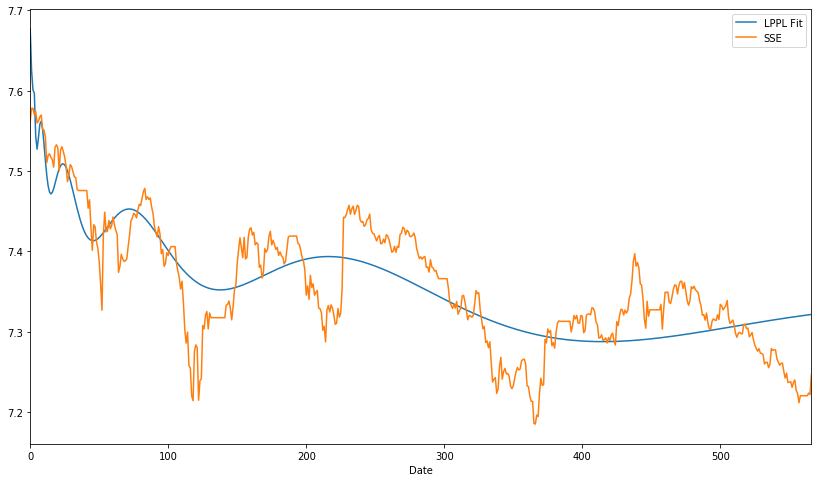

In [5]:
for i in solutions:
    tc = i["cof"][0]
    m =  i["cof"][1]
    w =  i["cof"][2]
    
    lin_vals = matrix_equation(tc, m, w)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]

    print("# tc = {}\n# m = {}\n# w = {}\n# a = {}\n# b = {}\n# c1 = {}\n# c2 = {}\n# -------------".format(tc,m,w,a,b,c1,c2))
    
    lppl_fit = [lppl_antibubble(t, tc, m, w, a, b, c1, c2) for t in DataSeries[0]]
    price_data = DataSeries[1]
    
    data = pd.DataFrame({
        'Date': DataSeries[0],
        'LPPL Fit': lppl_fit,
        'SSE': np.log(price_data),
    })
    data = data.set_index('Date')
    data.plot(figsize=(14,8))

In [6]:
data.to_excel('shanghai_lpplantibubble.xlsx')